In [1]:
import pymcsl as mcs
import numpy as np
import matplotlib.pyplot as plt

In [2]:
N_SUBSIMULATIONS = 1000
N_STEPS = 100

env = mcs.MonteCarloSimulationEnv(
    variables=[
        ('x', int, 0)
    ],
    n_subsimulations = N_SUBSIMULATIONS,
    n_steps = N_STEPS
)

In [3]:
LEFT = -1
RIGHT = 1

@env.subsim_begin
def beginf(context):
    context.direction = mcs.DiscreteRandomVariable({
        LEFT: 0.5,
        RIGHT: 0.5
    })
    
@env.subsim_step
def stepf(context, step):
    context.x += context.direction.evaluate()

In [4]:
env.run()

100%|██████████| 1000/1000 [00:03<00:00, 328.73it/s]


No handles with labels found to put in legend.


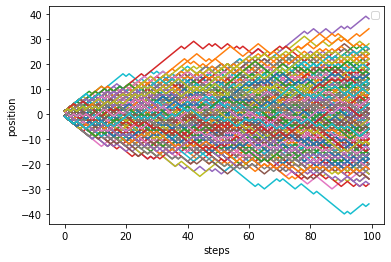

In [5]:
for i in range(N_SUBSIMULATIONS):
    h = env.get_subsim_env(i).get_variable_numpy_history('x')
    plt.plot(h)

plt.xlabel('steps')
plt.ylabel('position')
plt.legend()
plt.show()

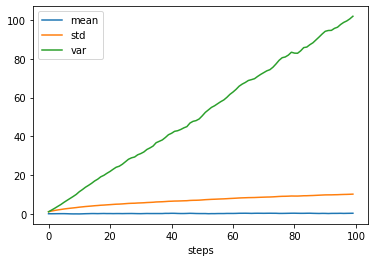

In [6]:
plt.plot(env.get_variable_mean('x'), label='mean')
plt.plot(env.get_variable_std('x'), label='std')
plt.plot(env.get_variable_var('x'), label='var')
plt.xlabel('steps')
plt.legend()
plt.show()

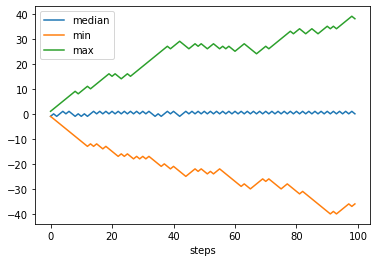

In [7]:
plt.plot(env.get_variable_median('x'), label='median')
plt.plot(env.get_variable_min('x'), label='min')
plt.plot(env.get_variable_max('x'), label='max')
plt.xlabel('steps')
plt.legend()
plt.show()

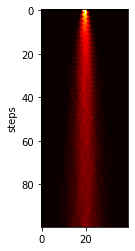

In [8]:
plt.imshow(env.get_variable_histogram('x', n_bins=40), cmap='hot')
plt.ylabel('steps')
plt.show()

(1000, 100)


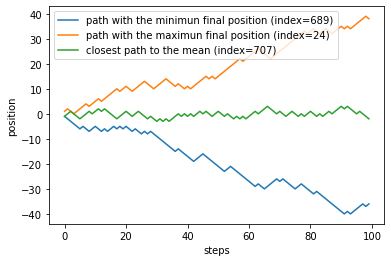

In [9]:
xh = env.get_variable_histories('x') #xh[subsim index, step index]
print(xh.shape)

#Find the subsimulation with the minimun final position
min_subsim_index = np.argmin([xh[subsim_index, N_STEPS-1] for subsim_index in range(N_SUBSIMULATIONS)])

#Find the subsimulation with the maximun final position
max_subsim_index = np.argmax([xh[subsim_index, N_STEPS-1] for subsim_index in range(N_SUBSIMULATIONS)])

#Find the subsimulation with the closest path to the mean
rmse = lambda a, b: np.mean(np.square(a-b)) #root mean square error
xmean = env.get_variable_mean('x')
av_subsim_index = np.argmin([rmse(xh[subsim_index, :], xmean) for subsim_index in range(N_SUBSIMULATIONS)])

plt.plot(xh[min_subsim_index, :], label=f'path with the minimun final position (index={min_subsim_index})')
plt.plot(xh[max_subsim_index, :], label=f'path with the maximun final position (index={max_subsim_index})')
plt.plot(xh[av_subsim_index, :], label=f'closest path to the mean (index={av_subsim_index})')
plt.xlabel('steps')
plt.ylabel('position')
plt.legend()
plt.show()